## Descripción del Proyecto

El proyecto **Rusty Bargain** se enfoca en desarrollar un modelo de machine learning que permita predecir el valor de mercado de autos usados. Esta aplicación está diseñada para ayudar a los usuarios a determinar rápidamente el precio de su vehículo basándose en datos históricos de especificaciones técnicas, versiones de equipamiento y precios.

### Objetivos Principales:
- **Calidad de la Predicción:** Garantizar predicciones precisas y alineadas con los valores de mercado.
- **Velocidad de Predicción:** Optimizar el modelo para ofrecer predicciones rápidas y eficientes.
- **Tiempo de Entrenamiento:** Minimizar el tiempo necesario para entrenar el modelo sin comprometer la precisión.


## Preparación de datos

* Importamos librerias

In [2]:
import numpy as np

import pandas as pd
from pandas.api.types import is_categorical_dtype, is_object_dtype

from matplotlib import pyplot as plt

import sklearn.neighbors
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb

* Cargamos los datos

In [3]:
df=pd.read_csv('/datasets/car_data.csv')

In [4]:
print(df.shape)
valor=round(df.shape[0]/2)#Divido el dataset, porque el kernel se cae
df=df[0:valor]
print(df.shape)

(354369, 16)
(177184, 16)


* Data wrangling

In [5]:
# Revisiòn general de los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177184 entries, 0 to 177183
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        177184 non-null  object
 1   Price              177184 non-null  int64 
 2   VehicleType        158480 non-null  object
 3   RegistrationYear   177184 non-null  int64 
 4   Gearbox            167282 non-null  object
 5   Power              177184 non-null  int64 
 6   Model              167265 non-null  object
 7   Mileage            177184 non-null  int64 
 8   RegistrationMonth  177184 non-null  int64 
 9   FuelType           160634 non-null  object
 10  Brand              177184 non-null  object
 11  NotRepaired        141576 non-null  object
 12  DateCreated        177184 non-null  object
 13  NumberOfPictures   177184 non-null  int64 
 14  PostalCode         177184 non-null  int64 
 15  LastSeen           177184 non-null  object
dtypes: int64(7), object(

In [6]:
#Asumimos que la fecha de publicaciòn del anuncio no influye en el precio de un auto, sino la fecha del modelo o de fabricaciòn
df=df.drop(['DateCrawled','DateCreated','LastSeen'],axis=1)
#Asì mismo es necesario considerar que 

In [7]:
#Revisemos la columna "NumberOfPictures", que cuenta con una constante ('0')
display(df['NumberOfPictures'].value_counts())
#Las características con valores constantes no aportan información útil para el modelo de machine learning, ya que no tienen variabilidad que el modelo pueda aprender para hacer predicciones.
df=df.drop(['NumberOfPictures'],axis=1)

0    177184
Name: NumberOfPictures, dtype: int64

In [8]:
#Analicemos la caracteristica "PostalCode"
#Esta puede considerarse como una caracteristica categorica, veamos cuando valores unicos tiene
print(df['PostalCode'].value_counts().count())
#Vemos que contiene demasiados (8143!), esta caracteristica puede ser considerada caracteristica de alta cardinalidad
#Esta columna serà eliminada, aunque puede ser codificada usando otros metodos como el de agrupar por region. 
df=df.drop(['PostalCode'],axis=1)

7976


In [9]:
#La columna 'RegistrationMonth', tampoco es importante, esto no deberìa influir en el precio de un vehiculo antiguo
from matplotlib  import pyplot as plt
precio_por_mes = df.groupby('RegistrationMonth')['Price'].mean()
print(precio_por_mes)
#Eliminaremos la columna "RegistrationMonth"
df=df.drop('RegistrationMonth',axis=1)

RegistrationMonth
0     1900.718447
1     4686.604763
2     4569.711598
3     4565.864484
4     4756.577627
5     4609.772646
6     4742.719361
7     4854.759093
8     4716.064033
9     4855.248288
10    4807.957732
11    4947.205577
12    4661.385791
Name: Price, dtype: float64


In [10]:
#Buscamos valores duplicados
print(f'tenemos {df.duplicated().sum()} valores duplicados')
#Eliminamos los valores duplicados
df=df.drop_duplicates()
#Buscamos valores duplicados
print(f'tenemos {df.duplicated().sum()} valores duplicados luego de eliminarlos')

tenemos 13413 valores duplicados
tenemos 0 valores duplicados luego de eliminarlos


In [11]:
#Analicemos la caracteristica price
#Tenemos algunas filas de la columna 'price' valoradas con 0. Eliminaremos estas filas para no confundir al algoritmo.
df=df[df['Price']!=0]

In [12]:
# Caracteristicas con valores nulos
null_values=['NotRepaired','FuelType','Model','Gearbox','VehicleType']
print()
print('Tenemos datos nulos en las siguientes columnas')
print()
print(df[null_values].isnull().sum())


Tenemos datos nulos en las siguientes columnas

NotRepaired    31222
FuelType       14465
Model           8580
Gearbox         7977
VehicleType    16262
dtype: int64


* Analicemos la columna 'RegistrationYear' que cuenta con valores fuera de lo normal

In [13]:
años=df['RegistrationYear'].value_counts(dropna=False).sort_index()
display(años)
#Existen valores fuera de lo normal en esta caracteristica (año 1,2290,1001)
#Tenemos 83 vehiculos con años de matriculaciòn superior a 2024
años_2024=df[df['RegistrationYear']>2024]
print(f'tenemos un total de {años_2024.shape[0]} observaciones con un año superior al 2024')
display(años_2024.head(10))

#Una caracteristica de estos vehiculos es que al menos tienen 4 columnas con valores nulos
#Contemos cuantos registros tienen al menos 4 columnas con valores nulos
null_counts = df.isnull().sum(axis=1).sort_values()

print("Registros que tienen al menos 3 columnas con valores nulos:")
print(null_counts[null_counts>=3])

#Eliminemos esos registros
df=df.drop(null_counts[null_counts>=3].index)

1000    16
1001     1
1234     4
1255     1
1400     1
        ..
8500     1
8888     1
9000     1
9450     1
9999     9
Name: RegistrationYear, Length: 122, dtype: int64

tenemos un total de 44 observaciones con un año superior al 2024


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
12946,49,NaN,5000,NaN,0,golf,5000,NaN,volkswagen,NaN
15870,1700,NaN,3200,NaN,0,NaN,5000,NaN,sonstige_autos,NaN
17271,700,NaN,9999,NaN,0,other,10000,NaN,opel,NaN
17346,6500,NaN,8888,NaN,0,NaN,10000,NaN,sonstige_autos,NaN
18259,300,NaN,2200,NaN,0,twingo,5000,NaN,renault,NaN
20159,1600,NaN,4100,NaN,0,NaN,5000,NaN,sonstige_autos,NaN
26382,150,NaN,3000,NaN,0,a_klasse,5000,NaN,mercedes_benz,NaN
26560,800,NaN,2066,NaN,0,zafira,5000,gasoline,opel,NaN
28390,799,NaN,9999,NaN,0,3er,10000,petrol,bmw,NaN
28965,18000,NaN,9999,NaN,0,a_klasse,10000,petrol,mercedes_benz,NaN


Registros que tienen al menos 3 columnas con valores nulos:
45253     3
114241    3
99837     3
34488     3
72748     3
         ..
23532     5
111925    5
65151     5
154477    5
1331      5
Length: 7446, dtype: int64


In [14]:
#Volvamos a revisar cuantos valores de la columna 'RegistrationYear' contienen valores por encima de 2024
años_2024=df[df['RegistrationYear']>2024]
display(años_2024)#Gran parte de estas observaciones tienen valores faltantes, por lo que las eliminaremos
df=df[df['RegistrationYear']<2024]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
46741,5000,NaN,2900,manual,120,corsa,5000,petrol,opel,NaN
46935,4900,NaN,6000,manual,52,NaN,10000,petrol,sonstige_autos,no
62629,12000,NaN,4000,manual,500,golf,5000,NaN,volkswagen,no
79383,1500,NaN,3700,manual,0,zafira,5000,cng,opel,NaN
79903,9000,NaN,5000,manual,420,impreza,5000,petrol,subaru,no
109285,1,NaN,6500,manual,120,other,10000,gasoline,peugeot,no
150717,200,NaN,5000,manual,0,corsa,5000,petrol,opel,yes


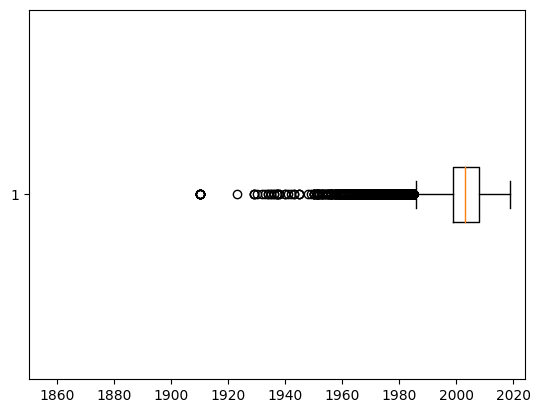

In [15]:
#Veamos por medio de un diagrama de caja y bigotes como se distribuyen los años ahora
plt.boxplot(df['RegistrationYear'],vert=False)
plt.xlim([1850,2024])
plt.show()

In [16]:
#Eliminaremos los valores extremos antes del año 1900
df=df[df['RegistrationYear']>1900]

In [17]:
#Remplazemos los valores faltantes de 'NotRepaired' por desc (desconocido)
df['NotRepaired']=df['NotRepaired'].fillna('desc')
#actualizamos la lista
null_values=['FuelType','Model','Gearbox','VehicleType']


* Veamos que proporciòn del total de datos representan los valores nulos en cada una de estas columnas

In [18]:
print(df[null_values].isnull().sum()/(df.shape[0]))

FuelType       0.056595
Model          0.036454
Gearbox        0.024615
VehicleType    0.065457
dtype: float64


* ¿Si elimináramos estos valores, qué porcentaje de los datos perderíamos?
- Perderiamos el 16% de los datos

In [19]:
print(1- (df.dropna().shape[0]/df.shape[0]))

0.15494872437868734


* Y si eliminaramos solo las observaciones con caraterisitcas 'Model y Gearbox'

In [20]:
print(1- (df.dropna(subset=['Model','Gearbox']).shape[0]/df.shape[0]))

0.06042208349281353


In [21]:
display(df.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,desc
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,desc
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


* Se perderían el 6% de los datos. Intentemos recuperar ese 16% de los datos usando el algoritmo KNN.
    * Para esto crearé una función que reciba el dataframe completo, una lista de las columnas categóricas y la columna que se desea rellenar. Y devolverá el dataframe con la columna rellena.

In [22]:
#Revisemos los tipos de datos
df.info()#El tipo de dato es correcto

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151534 entries, 0 to 177183
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             151534 non-null  int64 
 1   VehicleType       141615 non-null  object
 2   RegistrationYear  151534 non-null  int64 
 3   Gearbox           147804 non-null  object
 4   Power             151534 non-null  int64 
 5   Model             146010 non-null  object
 6   Mileage           151534 non-null  int64 
 7   FuelType          142958 non-null  object
 8   Brand             151534 non-null  object
 9   NotRepaired       151534 non-null  object
dtypes: int64(4), object(6)
memory usage: 12.7+ MB


In [23]:
#Funciòn para codificar datos
def MyEncodeDf(df, categorical_columns, encoding_method):
    df_encoded = df.copy()  # Crea una copia del DataFrame para evitar modificar el original
    
    if encoding_method == 'ordinalEncoder':
        encoder = OrdinalEncoder()
        for col in categorical_columns:
            if is_categorical_dtype(df_encoded[col]) or is_object_dtype(df_encoded[col]):
                df_encoded[col] = encoder.fit_transform(df_encoded[[col]])
    
    elif encoding_method == 'labelEncoder':
        encoder = LabelEncoder()
        for col in categorical_columns:
            if is_categorical_dtype(df_encoded[col]) or is_object_dtype(df_encoded[col]):
                df_encoded[col] = encoder.fit_transform(df_encoded[col])
    
    elif encoding_method == 'one-hot-encoding':
        df_encoded = pd.get_dummies(df_encoded, columns=categorical_columns)
    
    else:
        raise ValueError("El método de codificación debe ser 'ordinalEncoder', 'labelEncoder', o 'one-hot-encoding'")
    
    return df_encoded

def MyScalerDF(df, columns):
    df_scaled = df.copy()  # Creamos una copia del DataFrame para evitar modificar el original
    scaler = StandardScaler()
    
    # Guardamos los índices originales para reasignarlos después de escalarlos
    original_indices = df.index
    
    # Restablecemos el índice para alinear las columnas transformadas correctamente
    df_scaled.reset_index(drop=True, inplace=True)
    
    # Escalamos las columnas numéricas.
    df_scaled[columns] = scaler.fit_transform(df_scaled[columns])
    
    # Reasignamos los índices originales al DataFrame escalado
    df_scaled.index = original_indices
    
    return df_scaled

In [24]:
def MyKNNImputer(df_intern,categorical_columns,numerical_columns,target_column):
    df=df_intern.copy()
    #Almacenamos las columnas que no contienen valores nulos, excepto la columna objetivo a rellenar
    non_null_columns = [col for col in df.columns if col == target_column or df[col].isnull().sum() == 0]
    # Aplicar label encoding a las columnas categóricas
    cate_columns=list(set(categorical_columns) & set(non_null_columns))#columnas categoricas
    df=df[non_null_columns]
     # Reemplazar NaN en la columna objetivo con un valor temporal
    temp_nan_replacement = 'TEMP_NAN'
    df[target_column] = df[target_column].fillna(temp_nan_replacement)
    
    # Label encoding para la columna categórica
    label_encoders = {}
    for col in cate_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    
    # Encontrar la posición del valor temporal y reemplazarlo con np.nan
    nan_position = list(label_encoders[target_column].classes_).index(temp_nan_replacement)
    df[target_column] = df[target_column].replace(nan_position, np.nan) # Reemplazar el valor codificado por nulo
    
    num_columns = list(set(numerical_columns) & set(non_null_columns))
    
    
    # Escalar las columnas numéricas
    indices_originales = df.index.tolist()
    scaler = StandardScaler()
    df_to_scale = df[num_columns].copy()
    # Ajustar y transformar las columnas seleccionadas
    df_scaled = scaler.fit_transform(df_to_scale)
    # Crear un DataFrame con los datos escalados
    df_scaled = pd.DataFrame(df_scaled, columns=num_columns, index=df_to_scale.index)
    # Reemplazar las columnas originales con las escaladas en el DataFrame original
    df[num_columns] = df_scaled
    
    print(f'columnas consideradas {df.columns.to_list()}')
    print(f'Columnas numericas {num_columns}')
    print(f'columnas categoricas {cate_columns}')
    
     # Dividir el DataFrame en partes más pequeñas
    n_splits=10
    array_split = np.array_split(df, n_splits)
    chunks = [pd.DataFrame(parte) for parte in array_split]
    
    # Aplicar KNNImputer a cada parte y almacenar los resultados
    imputer = KNNImputer(n_neighbors=4)
    imputed_chunks = []
    n=10
    for chunk in chunks:
        df_imputed_chunk = pd.DataFrame(imputer.fit_transform(chunk), columns=chunk.columns)
        imputed_chunks.append(df_imputed_chunk)
        print(f'{n} % del relleno completo')
        n+=10
                                        
    # Unir los DataFrames imputados
    df_imputed = pd.concat(imputed_chunks, ignore_index=True)
    
    # Redondear y asegurar que los valores estén dentro del rango válido
    valid_labels = list(range(len(label_encoders[target_column].classes_)))
    df_imputed[target_column] = df_imputed[target_column].round().astype(int)
    df_imputed[target_column] = df_imputed[target_column].apply(lambda x: min(valid_labels, key=lambda y: abs(y - x)))
    
    # Revertir la codificación a las categorías originales
    df_imputed[target_column] = label_encoders[target_column].inverse_transform(df_imputed[target_column])
    
    return df_imputed[target_column]
    
    

In [25]:
#Reseteemos los indices 
df=df.reset_index(drop=True)#Este paso es importante, sino no coinciden los remplazos y algunas observaciones quedan con valores vacios
#Definamos las columnas categoricas y numericas
categorias=['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
numericas=list(set(df.columns.to_list())-set(categorias))
#Rellenamos la columna 'FuelType'
df['FuelType']=MyKNNImputer(df,categorias,numericas,'FuelType')

columnas consideradas ['Price', 'RegistrationYear', 'Power', 'Mileage', 'FuelType', 'Brand', 'NotRepaired']
Columnas numericas ['Power', 'RegistrationYear', 'Mileage', 'Price']
columnas categoricas ['NotRepaired', 'Brand', 'FuelType']
10 % del relleno completo
20 % del relleno completo
30 % del relleno completo
40 % del relleno completo
50 % del relleno completo
60 % del relleno completo
70 % del relleno completo
80 % del relleno completo
90 % del relleno completo
100 % del relleno completo


In [26]:
#Rellenemos Model ahora
df['Model']=MyKNNImputer(df,categorias,numericas,'Model')

columnas consideradas ['Price', 'RegistrationYear', 'Power', 'Model', 'Mileage', 'FuelType', 'Brand', 'NotRepaired']
Columnas numericas ['Power', 'RegistrationYear', 'Mileage', 'Price']
columnas categoricas ['NotRepaired', 'Brand', 'FuelType', 'Model']
10 % del relleno completo
20 % del relleno completo
30 % del relleno completo
40 % del relleno completo
50 % del relleno completo
60 % del relleno completo
70 % del relleno completo
80 % del relleno completo
90 % del relleno completo
100 % del relleno completo


In [27]:
#Rellenemos Gearbox ahora
df['Gearbox']=MyKNNImputer(df,categorias,numericas,'Gearbox')

columnas consideradas ['Price', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Mileage', 'FuelType', 'Brand', 'NotRepaired']
Columnas numericas ['Power', 'RegistrationYear', 'Mileage', 'Price']
columnas categoricas ['FuelType', 'NotRepaired', 'Brand', 'Model', 'Gearbox']
10 % del relleno completo
20 % del relleno completo
30 % del relleno completo
40 % del relleno completo
50 % del relleno completo
60 % del relleno completo
70 % del relleno completo
80 % del relleno completo
90 % del relleno completo
100 % del relleno completo


In [28]:
#Rellenemos VehicleType ahora
df['VehicleType']=MyKNNImputer(df,categorias,numericas,'VehicleType')

columnas consideradas ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Mileage', 'FuelType', 'Brand', 'NotRepaired']
Columnas numericas ['Power', 'RegistrationYear', 'Mileage', 'Price']
columnas categoricas ['VehicleType', 'FuelType', 'NotRepaired', 'Brand', 'Model', 'Gearbox']
10 % del relleno completo
20 % del relleno completo
30 % del relleno completo
40 % del relleno completo
50 % del relleno completo
60 % del relleno completo
70 % del relleno completo
80 % del relleno completo
90 % del relleno completo
100 % del relleno completo


In [29]:
print(df[null_values].isnull().sum())
#Ya no tenemos valores nulos.

FuelType       0
Model          0
Gearbox        0
VehicleType    0
dtype: int64


* El conjunto de datos esta listo

In [30]:
display(df.head(20))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,desc
1,18300,coupe,2011,manual,190,a6,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,desc
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,14500,bus,2014,manual,125,c_max,30000,petrol,ford,desc
8,999,small,1998,manual,101,golf,150000,petrol,volkswagen,desc
9,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no


## Entrenamiento del modelo 

In [31]:
%%time
#Generemos dos conjunto de datos, uno original como copia del original y otro con los datos transformados
df_original=df.copy()
df_encoded=MyEncodeDf(df_original,categorias,'labelEncoder')
df_transformed=MyScalerDF(df_encoded,['RegistrationYear','Power','Mileage'])
df_scaled=MyScalerDF(df_encoded,['RegistrationYear','Power','Mileage'])

CPU times: user 406 ms, sys: 35.4 ms, total: 441 ms
Wall time: 451 ms


In [32]:
def my_train_test_split(df,target_colum, random_state=54321, test_size=0.25):
        # Dividimos el dataset
        df_train, df_valid = train_test_split(df, random_state=54321, test_size=0.25)
        # Extraemos características y objetivos para capacitación y validación.
        features_train = df_train.drop([target_colum],axis=1)
        target_train = df_train[target_colum]
        features_valid = df_valid.drop([target_colum],axis=1)
        target_valid = df_valid[target_colum]
        return features_train,target_train,features_valid,target_valid

In [33]:
def MyrandomForestRegressor_Tester(df,target_colum,
                                   n_estimators_,
                                   max_depth_,
                                   min_samples_split_=2,
                                   max_features_='sqrt'):
    
    # Extraemos características y objetivos para capacitación y validación.
    features_train,target_train,features_valid,target_valid = my_train_test_split(df,target_colum, 
                                                                                  random_state=54321, 
                                                                                  test_size=0.25)
    
    # Creamos y entrenamos el modelo
    model = RandomForestRegressor(random_state=54321, 
                                  n_estimators=n_estimators_, 
                                  max_depth=max_depth_,
                                  min_samples_split=min_samples_split_,
                                  max_features=max_features_)
    model.fit(features_train, target_train)
        
    # Generamos las predicciones
    predictions_valid = model.predict(features_valid)
        
    # Calculamos RMSE
    rmse = mean_squared_error(target_valid, predictions_valid, squared=False)

    # imprimimos los resultados
    print(f"RMSE: {rmse}")
    return model

In [34]:
def MyCatBoostRegressor_Tester(df,target_colum,
                               cat_features_,
                               iterations_=500,
                               depth_=10,
                               learning_rate_=0.01,
                               loss_function_='RMSE',
                               verbose_=100):
    
    # Extraemos características y objetivos para capacitación y validación.
    features_train,target_train,features_valid,target_valid = my_train_test_split(df,target_colum, 
                                                                                  random_state=54321, 
                                                                                  test_size=0.25)
    
    # Creamos y entrenamos el modelo
    model = CatBoostRegressor(
        iterations=iterations_,
        depth=depth_,
        learning_rate=learning_rate_,
        loss_function=loss_function_,
        cat_features=cat_features_, # Especificamos las caracteristicas categoricas aquì
        random_seed=42)
    model.fit(features_train, target_train, eval_set=(features_valid, target_valid), verbose=verbose_)
    return model

In [35]:
def MyLightGBMRegressor_Tester(df, target_column, cat_features_,
                               iterations_=500, depth_=10,
                               learning_rate_=0.01, loss_function_='rmse',period=100):
    
    # Extraemos características y objetivos para capacitación y validación.
    features_train,target_train,features_valid,target_valid = my_train_test_split(df,target_column, 
                                                                                  random_state=54321, 
                                                                                  test_size=0.25)
    
    # Convertimos características categóricas a índices para LightGBM
    for col in cat_features_:
        features_train[col] = features_train[col].astype('category')
        features_valid[col] = features_valid[col].astype('category')

    
    # Configuración de parámetros para LightGBM
    # Creamos y entrenamos el modelo
    model = lgb.LGBMRegressor(
        n_estimators=iterations_,
        max_depth=depth_,
        learning_rate=learning_rate_,
        objective=loss_function_,
        categorical_feature=cat_features_,
        random_state=42
    )
    # Definir el callback de registro
    callbacks = [lgb.log_evaluation(period)]
    
    # Crear los datasets de LightGBM
    model.fit(features_train, target_train, 
              eval_set=[(features_train, target_train),(features_valid, target_valid)], 
              callbacks=callbacks)
    
    
    return model

* Dado que tenemos columnas categóricas con muchas características ('Model'con mas de 200), el one-hot encoding podría ser muy ineficiente en términos de memoria y tiempo de computación. En lugar de eso, usaremos la codificación ordinal.

In [36]:
def MyXGBoostRegressor_Tester(df, target_column, cat_features_, 
                              learning_rate_=0.01,
                              subsample_=1,
                              verbose_=100,
                              depth_=10,
                              iterations_=500,colsample_bytree_=1):
    
    # Extraemos características y objetivos de los datos para capacitación y validación.
    features_train, target_train, features_valid, target_valid = my_train_test_split(df, target_column, 
                                                                                     random_state=54321, 
                                                                                     test_size=0.25)
    # Creamos y entrenamos el modelo
    model = xgb.XGBRegressor(
        tree_method='hist',# Se recomienda usar 'hist' o 'approx'
        learning_rate=learning_rate_,
        subsample=subsample_,
        max_depth=depth_,
        objective='reg:squarederror',
        random_state=42,
        n_estimators=iterations_,
        colsample_bytree=colsample_bytree_)
    
    
    # Convertimos las características categóricas a tipo 'category'
    features_train = MyEncodeDf(features_train,cat_features_,'labelEncoder')
    features_valid = MyEncodeDf(features_valid,cat_features_,'labelEncoder')
    
    
    model.fit(features_train, target_train, 
              eval_set=[(features_train, target_train),(features_valid, target_valid)], 
              eval_metric='rmse',verbose=verbose_)

    return model

* NO USAREMOS LinearRegression PARA HACER PRUEBA DE CORDURA PORQUE EL ENETRENAMIENTO DEMASIADO

## Análisis del modelo

### RandomForestRegressor

In [37]:
%%time
#Entrenemos un algoritmo de regresiòn basado en arboles de decisiòn (RandomForestRegressor).
#Sin las características numéricas escaladas
Model_1=MyrandomForestRegressor_Tester(df_transformed,'Price',100,20,min_samples_split_=3,max_features_='sqrt')
#"El modelo retorna el mismo rmse independientemente de si los datos se entregan escalados o no.

RMSE: 1712.9531500635392
CPU times: user 15.3 s, sys: 85.2 ms, total: 15.4 s
Wall time: 15.6 s


In [38]:
%%time
#Con las caracteristicas numericas escaladas
Model_2=MyrandomForestRegressor_Tester(df_encoded,'Price',100,20)
#El modelo retorna el mismo rmse independientemente de si los datos se entregan escalados o no.

RMSE: 1714.63723477043
CPU times: user 16.1 s, sys: 158 ms, total: 16.3 s
Wall time: 16.3 s


### CatBoostRegressor

In [39]:
# Potenciaciòn del gradiente usando CatBoostRegressor
#depth_=6
Model_3=MyCatBoostRegressor_Tester(df_scaled,'Price',categorias,depth_=6,learning_rate_=0.05,iterations_=500,verbose_=100,)
# El modelo retorna el mismo rmse independientemente de si los datos se entregan escalados o no.

0:	learn: 4446.4290814	test: 4442.6794963	best: 4442.6794963 (0)	total: 306ms	remaining: 2m 32s
100:	learn: 1913.6094074	test: 1923.7512734	best: 1923.7512734 (100)	total: 21.3s	remaining: 1m 24s
200:	learn: 1801.3757398	test: 1824.3675733	best: 1824.3675733 (200)	total: 40.9s	remaining: 1m
300:	learn: 1747.7438360	test: 1781.6704919	best: 1781.6704919 (300)	total: 1m 1s	remaining: 40.5s
400:	learn: 1713.4839867	test: 1755.6394541	best: 1755.6394541 (400)	total: 1m 21s	remaining: 20.1s
499:	learn: 1691.4541794	test: 1742.2838407	best: 1742.2838407 (499)	total: 1m 41s	remaining: 0us

bestTest = 1742.283841
bestIteration = 499



In [40]:
# Potenciaciòn del gradiente usando CatBoostRegressor
#depth_=5
#learning_rate_=0.1
Model_4=MyCatBoostRegressor_Tester(df_scaled,'Price',categorias,depth_=5,learning_rate_=0.1,iterations_=500,verbose_=100,)
#El modelo retorna un rmse igual indiferentemente de si los datos los estrego escalados o no.

0:	learn: 4317.2459810	test: 4314.0227696	best: 4314.0227696 (0)	total: 196ms	remaining: 1m 37s
100:	learn: 1853.5074013	test: 1871.0671034	best: 1871.0671034 (100)	total: 16.9s	remaining: 1m 6s
200:	learn: 1763.6390489	test: 1794.3554160	best: 1794.3554160 (200)	total: 33.3s	remaining: 49.5s
300:	learn: 1720.6561358	test: 1762.1666145	best: 1762.1666145 (300)	total: 49.6s	remaining: 32.8s
400:	learn: 1691.1114143	test: 1743.6614759	best: 1743.6614759 (400)	total: 1m 6s	remaining: 16.3s
499:	learn: 1669.0536611	test: 1731.1725424	best: 1731.1725424 (499)	total: 1m 22s	remaining: 0us

bestTest = 1731.172542
bestIteration = 499



### LightGBMRegressor

In [42]:
%%time
# Potenciaciòn del gradiente usando LightGBM
#depth_=4
#learning_rate_=0.01
Model_4 = MyLightGBMRegressor_Tester(df_scaled, 'Price', categorias, depth_=4, learning_rate_=0.01, iterations_=600)
#El modelo retorna un rmse igual indiferentemente de si los datos los estrego escalados o no.

[100]	training's rmse: 2821.08	valid_1's rmse: 2829.5
[200]	training's rmse: 2206.02	valid_1's rmse: 2222.14
[300]	training's rmse: 1970.98	valid_1's rmse: 1993.43
[400]	training's rmse: 1869.46	valid_1's rmse: 1897.22
[500]	training's rmse: 1816.27	valid_1's rmse: 1850.06
[600]	training's rmse: 1781.29	valid_1's rmse: 1821.34
CPU times: user 12.8 s, sys: 72.5 ms, total: 12.9 s
Wall time: 13 s


In [43]:
%%time
# Potenciaciòn del gradiente usando LightGBM
#depth_=10
#learning_rate_=0.1
Model_4 = MyLightGBMRegressor_Tester(df_scaled, 'Price', categorias, depth_=10, learning_rate_=0.1, iterations_=600)
#El modelo retorna un rmse igual indiferentemente de si los datos los estrego escalados o no.

[100]	training's rmse: 1600.52	valid_1's rmse: 1704.79
[200]	training's rmse: 1525.18	valid_1's rmse: 1676.56
[300]	training's rmse: 1481.15	valid_1's rmse: 1665.02
[400]	training's rmse: 1446.03	valid_1's rmse: 1657.46
[500]	training's rmse: 1420.05	valid_1's rmse: 1653.25
[600]	training's rmse: 1394.5	valid_1's rmse: 1650.3
CPU times: user 10.7 s, sys: 77.4 ms, total: 10.8 s
Wall time: 10.9 s


### XGBoostRegressor

In [44]:
%%time
# Potenciaciòn del gradiente usando XGBoost
#learning_rate_=0.01
#depth_=8
#subsample_=1
#colsample_bytree_=0.5
Model_5=MyXGBoostRegressor_Tester(df_encoded, 'Price', categorias, 
                                  learning_rate_=0.01,subsample_=1,
                                  depth_=8,iterations_=600,colsample_bytree_=0.5)

[0]	validation_0-rmse:6540.74316	validation_1-rmse:6515.29736
[100]	validation_0-rmse:3409.66064	validation_1-rmse:3415.06567
[200]	validation_0-rmse:2268.25659	validation_1-rmse:2306.09106
[300]	validation_0-rmse:1894.02930	validation_1-rmse:1959.99927
[400]	validation_0-rmse:1748.74353	validation_1-rmse:1835.45789
[500]	validation_0-rmse:1676.78564	validation_1-rmse:1781.32654
[599]	validation_0-rmse:1629.82861	validation_1-rmse:1748.61694
CPU times: user 36.9 s, sys: 342 ms, total: 37.3 s
Wall time: 37.6 s


In [45]:
%%time
# Potenciaciòn del gradiente usando XGBoost
#learning_rate_=0.1
#depth_=6
#subsample_=0.8
Model_5=MyXGBoostRegressor_Tester(df_encoded, 'Price', categorias, 
                                  learning_rate_=0.1,subsample_=0.7,
                                  depth_=6,iterations_=600,colsample_bytree_=0.7)

[0]	validation_0-rmse:6060.47900	validation_1-rmse:6037.18164
[100]	validation_0-rmse:1679.45166	validation_1-rmse:1768.42517
[200]	validation_0-rmse:1587.04517	validation_1-rmse:1728.50171
[300]	validation_0-rmse:1527.58130	validation_1-rmse:1709.02368
[400]	validation_0-rmse:1483.79358	validation_1-rmse:1696.67761
[500]	validation_0-rmse:1449.26721	validation_1-rmse:1690.52673
[599]	validation_0-rmse:1420.79504	validation_1-rmse:1684.19592
CPU times: user 23.7 s, sys: 141 ms, total: 23.8 s
Wall time: 24.2 s


## CONCLUSIÒN

El proyecto logró desarrollar un modelo predictivo efectivo para estimar el valor de mercado de autos usados en la plataforma Rusty Bargain. De los modelos evaluados, el **LightGBMRegressor** demostró ser la opción más equilibrada, ofreciendo una combinación óptima de velocidad y precisión con un RMSE de 1650. Además, **XGBoostRegressor** y **CatBoostRegressor** también mostraron un rendimiento competitivo, aunque a un costo mayor en términos de tiempo de entrenamiento.

En cuanto a la velocidad de predicción, **LightGBMRegressor** fue significativamente más rápido, consolidándose como la mejor opción para un entorno de producción donde la rapidez es esencial. La implementación de técnicas de preprocesamiento de datos, como la codificación ordinal y el escalado, fue clave para mejorar el rendimiento de los modelos.

Este proyecto no solo proporciona una solución práctica para la valoración de autos usados, sino que también establece una base sólida para futuras mejoras, como la incorporación de factores regionales y estacionales que podrían influir en los precios del mercado.
